## Two-layer Territory Management. Optimizing territories considering clients and sales reps

In territory management, a territory is a customer group or geographic area over which either an individual salesperson or a sales team has responsibility. These territories are usually defined based on geography, sales potential, number of clients or a combination of these factors.

The main complexity in territory management is to create areas that are balanced with regards to more than one factor that usually behave very differently. There is no one-size-fits-all solution, and if the balance is off, sales management is likely to leave someone within their organization unhappy or leave money on the table. This is why it is very important to identify and understand all the components and requirements of your use case to apply the most appropriate technique.

We can differentiate between two main use cases: when the location of sales reps is important (usually because they have to travel to visit their clients) and when it is not (travel rarely occurs). The first case is clearly more complex than the latter.

In this notebook we will work on a Territory Management problem in which clusters need to be balanced in terms of number of clients and distance to their sales rep. This way, we will have two layers of data: one consisting of the client locations and the other one with the sales rep locations. We will prove the value Spatial Data Science techniques by showing their additional value compared to traditional techniques.

### Use case description

A pharma lab is interested in balancing their sales territories in the state of Texas based on the number of current and potential clients per territory. They would also like these clusters to be close to sales reps locations since they usually have to travel to visit them.

Their clients are mainly offices and clinics of medical doctors.

They are interested in creating 5 balanced territories taking into account number of clients and distance traveled.

We will use the following three datasets from [CARTO's Data Observatory](https://carto.com/spatial-data-catalog/):
- Points of Interest (POIs). In particular, office and clinic of medical doctors POIs. We will use [Pitney Bowes POI-Consumer dataset](https://carto.com/spatial-data-catalog/browser/dataset/pb_consumer_po_62cddc04/).
- Texas boundary geometry. We'll use [Who's on First GeoJSON - Global dataset](https://carto.com/spatial-data-catalog/browser/geography/wof_geojson_4e78587c/).
- Sales rep locations. This dataset is provided by the client.

*Note* the POI dataset is premium and a subscription is needed to access this data.

### 0. Setup

We'll start by importing all packages we'll use.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from cartoframes.auth import set_default_credentials
from cartoframes.data.observatory import *
from cartoframes.viz import *
from h3 import h3
from libpysal.weights import Rook
from ortools.graph import pywrapgraph
from scipy.spatial.distance import cdist
from shapely import wkt
from shapely.geometry import mapping, Polygon
from sklearn.cluster import KMeans
from splot.libpysal import plot_spatial_weights

pd.set_option('display.max_columns', None)
plt.rc('axes', titlesize='large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
sns.set_style('whitegrid')

In order to be able to use the Data Observatory via CARTOframes, you need to set your CARTO account credentials first.

Please, visit the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/) for further detail.

In [2]:
set_default_credentials('creds.json')

#### 0.1. Functions

The following function creates an [H3](https://eng.uber.com/h3/) polyfill of the polygon and at the resolution indicated.

In [3]:
def create_h3_grid(polygon, resolution=8):
    hex_id_list = list(h3.polyfill(geojson = mapping(polygon), res = resolution, geo_json_conformant=True))
    hexagon_list = list(map(lambda x : Polygon(h3.h3_to_geo_boundary(h=x, geo_json=True)), hex_id_list))
    grid = pd.DataFrame(data={'hex_id':hex_id_list, 'geometry':hexagon_list})
    grid = gpd.GeoDataFrame(grid, crs='epsg:4326')
    return grid

The function below is used throughout the analysis to check is clusters are balanced based on different metrics.

The function arguments are:
- `cluster_names` so that we can provide descriptive names to clusters
- `areas_df` is the GeoDataFrame
- `groupby` is the column with the cluster to which each cell belongs to
- `**kaggregations` for the different metrics we'd like to calculate

In [4]:
def plot_cluster_comparison(cluster_names, areas_df, groupby, **kaggregations):
    areas_df_g = areas_df.groupby(groupby).agg(kaggregations).reset_index()

    n_plots = len(kaggregations)
    fig, axs = plt.subplots(1, n_plots, figsize=(9 + 3*n_plots,4))
    if n_plots == 1:
        axs = [axs]
    
    for i in range(n_plots):
        sns.barplot(y=groupby, x=list(kaggregations.keys())[i], data=areas_df_g, order=cluster_names, 
                    palette=['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74'], ax=axs[i])
        axs[i].set_xlabel(list(kaggregations.keys())[i], fontsize=13)
        axs[i].set_ylabel('Sales rep locations', fontsize=13)
    
    fig.tight_layout()

### 1. Download and visualize data

Next, we will download the data described in the usecase using [CARTOframes](https://carto.com/developers/cartoframes/).

*Note* in this notebook some prior knowledge on how to explore and download data from the [Data Observatory](https://carto.com/spatial-data-catalog/) is assumed. If this is your first time exploring and downloading data from the [Data Observatory](https://carto.com/spatial-data-catalog/), take a look at [CARTOframes Guides](https://carto.com/developers/cartoframes/guides/Introduction/) and the [Data Observatory examples](https://carto.com/developers/cartoframes/guides/Data-Observatory/) and **discover how easy it is to get started!**

#### 1.1 Texas boundary geometry

We are interested in the geometry of the state of Texas. We'll download it from [Who's on First GeoJSON - Global dataset](https://carto.com/spatial-data-catalog/browser/geography/wof_geojson_4e78587c/).

In [5]:
wof_grographies = Geography.get('wof_geojson_4e78587c')
wof_grographies.to_dict()

{'slug': 'wof_geojson_4e78587c',
 'name': 'GeoJSON - Global',
 'description': "The main table in Who's On First. Holds all the relevant information for a place in the 'body' JSON field.",
 'country_id': 'glo',
 'provider_id': 'whos_on_first',
 'geom_type': 'MULTIPLE',
 'update_frequency': None,
 'is_public_data': True,
 'lang': 'eng',
 'version': '20190520',
 'provider_name': "Who's On First",
 'id': 'carto-do-public-data.whos_on_first.geography_glo_geojson_20190520'}

In [6]:
state_name = 'Texas'
country_code = 'US'
placetype = 'region'

sql_query = f"""SELECT * 
                FROM $geography$ 
                WHERE name = '{state_name}' AND 
                      country = '{country_code}' AND 
                      placetype='{placetype}'"""

tx_boundary = wof_grographies.to_dataframe(sql_query=sql_query)
tx_boundary.crs='epsg:4326'
tx_boundary['geom'] = tx_boundary.simplify(0.01)
tx_boundary

geoid        id                                               body  \
0  85688753  85688753  {"id": 85688753, "type": "Feature", "propertie...   

    name country  parent_id  is_current placetype geometry_type  \
0  Texas      US   85633793           1    region       Polygon   

                                                bbox  \
0  POLYGON((-93.508039 25.837164, -93.508039 36.5...   

                                                geom  lastmodified  \
0  POLYGON ((-103.06466 32.95910, -103.06442 32.0...    1555446728   

      lastmodified_timestamp  
0  2019-04-16 20:32:08+00:00

#### 1.2. Client locations

We'll download all POIs in Texas classified as "OFFICES AND CLINICS OF MEDICAL DOCTORS" from [Pitney Bowes POI-Consumer dataset](https://carto.com/spatial-data-catalog/browser/dataset/pb_consumer_po_62cddc04/).

*Note* this is a premium dataset and a subscription is required.

In [7]:
poi_dataset = Dataset.get('pb_consumer_po_62cddc04')

In [8]:
sql_query = """
    SELECT * except(do_label) FROM $dataset$ 
    WHERE SUB_CLASS = 'OFFICES AND CLINICS OF MEDICAL DOCTORS' 
    AND STABB = 'TX'
    AND CAST(do_date AS date) >= (SELECT MAX(CAST(do_date AS date)) from $dataset$)
"""
pois = poi_dataset.to_dataframe(sql_query=sql_query)
pois.columns = list(map(str.lower, pois.columns))
pois.crs='epsg:4326'
pois.head()

/Users/malvarez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (6,10,27,44,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


geoid     do_date  \
0   1128750296#-96.398536#32.469934  2020-08-01   
1   1217171653#-96.858002#32.715481  2020-08-01   
2   1123005494#-97.104542#32.926825  2020-08-01   
3  1221252299#-101.902112#33.573453  2020-08-01   
4   1217934291#-95.419502#29.170283  2020-08-01   

                                     name brandname       pb_id  \
0       SIMMONS & ASSOC SOUTH CENTRAL LLC       NaN  1128750296   
1  SOUTHWEST DALLAS ORTHOPEDIC ASSOCIATES       NaN  1217171653   
2                     S ROBERT HARLA DOPA       NaN  1123005494   
3  CONSULTANTS IN INFECTIOUS DISEASES LLP       NaN  1221252299   
4                         SUZAN CARPENTER       NaN  1217934291   

              trade_name franchise_name iso3  areaname4  areaname3 areaname2  \
0   SIMMONS & ASSOCIATES            NaN  USA        NaN     SCURRY       NaN   
1                    NaN            NaN  USA        NaN     DALLAS       NaN   
2  GRAPEVINE DERMATOLOGY            NaN  USA        NaN  GRAPEVINE       NaN   
3                    NaN            NaN  USA        NaN    LUBBOCK       NaN   
4   CARPENTER, SU ZAN MD            NaN  USA        NaN   ANGLETON       NaN   

  areaname1 stabb    postcode  \
0     TEXAS    TX  75158-3304   
1     TEXAS    TX  75224-3059   
2     TEXAS    TX  76051-8632   
3     TEXAS    TX  79410-1804   
4     TEXAS    TX  77515-5836   

                                    formattedaddress  \
0               9084 FM 2451, SCURRY, TX, 75158-3304   
1  2909 S HAMPTON RD STE D121, DALLAS, TX, 75224-...   
2  2321 IRA E WOODS AVE STE 180, GRAPEVINE, TX, 7...   
3      4102 24TH ST STE 403, LUBBOCK, TX, 79410-1804   
4          1113 E CEDAR ST, ANGLETON, TX, 77515-5836   

                mainaddressline            addresslastline   longitude  \
0                  9084 FM 2451     SCURRY, TX, 75158-3304  -96.398536   
1    2909 S HAMPTON RD STE D121     DALLAS, TX, 75224-3059  -96.858002   
2  2321 IRA E WOODS AVE STE 180  GRAPEVINE, TX, 76051-8632  -97.104542   
3          4102 24TH ST STE 403    LUBBOCK, TX, 79410-1804 -101.902112   
4               1113 E CEDAR ST   ANGLETON, TX, 77515-5836  -95.419502   

    latitude   georesult confidence_code  country_access_code         tel_num  \
0  32.469934  S8HPNTSCZA            HIGH                  1.0  (972) 452-8013   
1  32.715481  S8HPNTSCZA            HIGH                  1.0  (214) 333-3741   
2  32.926825  S8HPNTSCZA            HIGH                  1.0  (817) 329-2263   
3  33.573453  S8HPNTSCZA            HIGH                  1.0  (806) 725-7150   
4  29.170283  S8HPNTSCZA            HIGH                  1.0  (979) 849-5703   

  faxnum email                 http  open_24h  \
0    NaN   NaN   WWW.SIMMONSINC.COM       NaN   
1    NaN   NaN  WWW.DALLASORTHO.COM       NaN   
2    NaN   NaN      WWW.DERMDFW.COM       NaN   
3    NaN   NaN  WWW.COVMEDGROUP.ORG       NaN   
4    NaN   NaN                  NaN       NaN   

                             business_line    sic1  sic2      sic8  \
0  OFFICES AND CLINICS MEDICAL DOCTORS,NSK  8011.0   NaN  80110000   
1  OFFICES AND CLINICS MEDICAL DOCTORS,NSK  8011.0   NaN  80110514   
2  OFFICES AND CLINICS MEDICAL DOCTORS,NSK  8011.0   NaN  80110503   
3  OFFICES AND CLINICS MEDICAL DOCTORS,NSK  8011.0   NaN  80110510   
4  OFFICES AND CLINICS MEDICAL DOCTORS,NSK  8011.0   NaN  80119901   

                                   sic8_description  alt_industry_code  \
0            OFFICES AND CLINICS OF MEDICAL DOCTORS           621111.0   
1                              ORTHOPEDIC PHYSICIAN           621111.0   
2                                     DERMATOLOGIST           621111.0   
3  INFECTIOUS DISEASE SPECIALIST, PHYSICIAN/SURGEON           621111.0   
4    GENERAL AND FAMILY PRACTICE, PHYSICIAN/SURGEON           621111.0   

     micode          trade_division            group  \
0  10238011  DIVISION I. - SERVICES  HEALTH SERVICES   
1  10942514  DIVISION I. - SERVICES  HEALTH SERVICES   
2  10942503  DIVISION I. - SERVICES  HEALT

In [9]:
pois.shape

(59554, 74)

#### 1.3. Sales reps

In [11]:
sales_reps = pd.read_csv('data/sales_reps.csv')
sales_reps['geometry'] = gpd.points_from_xy(sales_reps['lon'], sales_reps['lat'])
sales_reps = gpd.GeoDataFrame(sales_reps, crs='epsg:4326')
sales_reps

id         city state_name        lat         lon  \
0   0       Dallas      Texas  32.725728  -96.844694   
1   1       Austin      Texas  30.255450  -97.729611   
2   2  San Antonio      Texas  29.424510  -98.524053   
3   3      Houston      Texas  29.778360  -95.332154   
4   4      El Paso      Texas  31.795306 -106.456893   

                      geometry  
0   POINT (-96.84469 32.72573)  
1   POINT (-97.72961 30.25545)  
2   POINT (-98.52405 29.42451)  
3   POINT (-95.33215 29.77836)  
4  POINT (-106.45689 31.79531)

#### 1.4. Visualize data

In [12]:
Map([Layer(tx_boundary,
           style=basic_style(opacity=0, stroke_color='#11A579', stroke_width=5),
           legends=basic_legend('Texas Boundary')),
     Layer(pois.sample(5000), 
           style=basic_style(color='#F2B701', size=2, opacity=0.9, stroke_width=0),
           popup_hover=[popup_element('name', 'Client'),
                        popup_element('employee_here', '# Employees')],
           legends=basic_legend('Client Locations')),
     Layer(sales_reps,
           style=basic_style(color='red', size=5, stroke_width=0),
           popup_hover=popup_element('city', 'City'),
           legends=basic_legend('Sales Rep Locations'))], 
    basemap=basemaps.darkmatter)

### 2. Discretize space. H3 grid

A fundamental step in territory management is to discretize space. Territory management algorithms are computationally complex and hence it is crucial to leverage the spatial component to reduce complexity. We can do this by working at an aggregated level instead of considering each client location independently.

We first need to identify the smallest spatial aggregation that makes sense for your business, our **geographic support**. This can be census block groups, zip codes or counties, or you can be interested in using a standard grid, in which case it would ideally be a hierarchical spatial index such as [Quadkey grid](https://docs.microsoft.com/en-us/azure/azure-maps/zoom-levels-and-tile-grid?tabs=csharp) or [H3 grid](https://eng.uber.com/h3/).

In this notebook we will use an H3 grid of resolution 5. We can easily discretize space by performing a polyfill of the Texas boundary polygon. 

*Note* a buffer has been applied because H3 will fill the polygon with all hexagons of resolution 5 whose centroid lies within the polygon to be filled and we want to make sure the whole territory is covered.

In [13]:
# Buffer
buffer = 1e4  # in meters
tx_boundary['geometry_buffer'] = tx_boundary.to_crs('epsg:26914').buffer(buffer).to_crs('epsg:4326')

grid = create_h3_grid(tx_boundary['geometry_buffer'].iloc[0], 5)
grid.head()

hex_id                                           geometry
0  8526d9d7fffffff  POLYGON ((-99.33557 32.87875, -99.26773 32.953...
1  8526d9a3fffffff  POLYGON ((-98.71570 32.47235, -98.64788 32.546...
2  8526dc1bfffffff  POLYGON ((-100.32151 34.39136, -100.25314 34.4...
3  85446c77fffffff  POLYGON ((-94.98183 29.87978, -94.91454 29.952...
4  85444db7fffffff  POLYGON ((-95.10421 32.87010, -95.03517 32.941...

In [14]:
Map([Layer(grid,
           style=basic_style(opacity=0.75),
           legends=basic_legend('H3 grid')),
     Layer(tx_boundary,
           style=basic_style(opacity=0, stroke_color='#E73F74', stroke_width=5),
           legends=basic_legend('Texas Boundary'))])

#### 2.1. Aggregate client info at the grid level.

We will aggregate clients by:
- Counting the number of clients per cell
- Calculating the median rating of clients within eack cell

In [15]:
pois_g = gpd.sjoin(pois, grid, how='right').groupby('hex_id').agg({'geoid':'count', 'employee_here':'mean'}).\
            reset_index().rename(columns={'geoid':'poi_count', 'employee_here':'employee_avg'})
pois_g[['poi_count', 'employee_avg']] = pois_g[['poi_count', 'employee_avg']].fillna(0)
areas = grid.merge(pois_g, on='hex_id')
areas = gpd.GeoDataFrame(areas, crs='epsg:4326')
areas.head()

hex_id                                           geometry  \
0  8526d9d7fffffff  POLYGON ((-99.33557 32.87875, -99.26773 32.953...   
1  8526d9a3fffffff  POLYGON ((-98.71570 32.47235, -98.64788 32.546...   
2  8526dc1bfffffff  POLYGON ((-100.32151 34.39136, -100.25314 34.4...   
3  85446c77fffffff  POLYGON ((-94.98183 29.87978, -94.91454 29.952...   
4  85444db7fffffff  POLYGON ((-95.10421 32.87010, -95.03517 32.941...   

   poi_count  employee_avg  
0          0      0.000000  
1          0      0.000000  
2          0      0.000000  
3         13      3.833333  
4          1      3.000000

In [16]:
areas['poi_count'].describe(percentiles=[0.75, 0.9, 0.975, 0.99])

count    2584.000000
mean       23.047214
std       151.594386
min         0.000000
50%         0.000000
75%         1.000000
90%        14.000000
97.5%     226.000000
99%       571.870000
max      3471.000000
Name: poi_count, dtype: float64

In [17]:
breaks = [15, 200, 550]

Map([Layer(areas[areas['poi_count'] > 0], 
           style=color_bins_style('poi_count', breaks=breaks),
           legends=color_bins_legend('Number of Clients')),
     Layer(sales_reps, 
           style=basic_style('#F2B701'), 
           popup_hover=popup_element('city'),
           legends=basic_legend('Sales Reps'))])

### 3. Territory Optimization

Once we have our data aggregated, it's time to start working on building balanced territories.

It is important to note that clients mainly concentrate around sales rep locations, and there are large areas with a very low density of clients. In addition, the sales rep in El Paso is very far from Eastern Texas, where most clients concentrate. This means it's going to be very challenging to balance distance and number of clients, especially for the sales rep in El Paso.

We will explore two different techniques:
- Closest distance.
- [Minimum cost flow approach](https://en.wikipedia.org/wiki/Minimum-cost_flow_problem#:~:text=The%20minimum%2Dcost%20flow%20problem,flow%20through%20a%20flow%20network.). 

#### 3.1. Data preparation

For both techniques we need to calculate sales rep - client distance matrix.


**Distance metric**

*Note* different distance metrics can be used for calculating distance. Results change significantly wdepending on this metric.
 - `metric`: Distance metric. [Here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) you can find all available metrics.

In [18]:
metric = 'cityblock'  # 'euclidean'

**Representative point**

In order to calculate distances, we need a reference location for each cell. Since we are using regular polygons, we can use the centroid. However, selecting the centroid is discouraged with non-convex geometries as they may have their centroid out of the polygon. If that's the case, the Shapely function `representative_point()` returns a point within the polygon.

In [19]:
areas['rep_point'] = areas['geometry'].centroid
areas.head()

hex_id                                           geometry  \
0  8526d9d7fffffff  POLYGON ((-99.33557 32.87875, -99.26773 32.953...   
1  8526d9a3fffffff  POLYGON ((-98.71570 32.47235, -98.64788 32.546...   
2  8526dc1bfffffff  POLYGON ((-100.32151 34.39136, -100.25314 34.4...   
3  85446c77fffffff  POLYGON ((-94.98183 29.87978, -94.91454 29.952...   
4  85444db7fffffff  POLYGON ((-95.10421 32.87010, -95.03517 32.941...   

   poi_count  employee_avg                    rep_point  
0          0      0.000000   POINT (-99.37959 32.96652)  
1          0      0.000000   POINT (-98.75897 32.56035)  
2          0      0.000000  POINT (-100.36707 34.47834)  
3         13      3.833333   POINT (-95.02049 29.96866)  
4          1      3.000000   POINT (-95.14402 32.95831)

**Distance array**

In [20]:
dist_array = cdist(gpd.GeoSeries(areas['rep_point'], crs='epsg:4326').to_crs('epsg:26914').apply(lambda point:[point.x, point.y]).tolist(),
                   sales_reps['geometry'].to_crs('epsg:26914').apply(lambda point:[point.x, point.y]).tolist(),
                   metric=metric)

#### 3.2. Approach 1. Closest sales rep

This is a very simple approach in which every grid cell is assigned to its closer sales rep.

In [21]:
areas['sales_rep_1'] = list(map(np.argmin, dist_array))
areas['sales_rep_1_cat'] = sales_reps.loc[areas['sales_rep_1'], 'city'].tolist()
areas['sales_rep_dist_1'] = list(map(np.min, dist_array))
areas.head()

hex_id                                           geometry  \
0  8526d9d7fffffff  POLYGON ((-99.33557 32.87875, -99.26773 32.953...   
1  8526d9a3fffffff  POLYGON ((-98.71570 32.47235, -98.64788 32.546...   
2  8526dc1bfffffff  POLYGON ((-100.32151 34.39136, -100.25314 34.4...   
3  85446c77fffffff  POLYGON ((-94.98183 29.87978, -94.91454 29.952...   
4  85444db7fffffff  POLYGON ((-95.10421 32.87010, -95.03517 32.941...   

   poi_count  employee_avg                    rep_point  sales_rep_1  \
0          0      0.000000   POINT (-99.37959 32.96652)            0   
1          0      0.000000   POINT (-98.75897 32.56035)            0   
2          0      0.000000  POINT (-100.36707 34.47834)            0   
3         13      3.833333   POINT (-95.02049 29.96866)            3   
4          1      3.000000   POINT (-95.14402 32.95831)            0   

  sales_rep_1_cat  sales_rep_dist_1  
0          Dallas     262156.516612  
1          Dallas     199715.113991  
2          Dallas     520625.827092  
3         Houston      51541.627399  
4          Dallas     188844.476467

##### 3.2.1. Visualize and analyze results

As we presumed, we can see clusters are unbalanced both in terms of number of clients and maximum distance because of the very uneven spatial distribution of clients.

Main issues to tacke:
- Dallas gets almost 10 times as many clients as El Paso.
- El Paso and Dallas sales reps max distance more than doubles that from Houston sales rep.

In [22]:
Map([Layer(areas[areas['poi_count'] > 0],
           style=color_category_style('sales_rep_1_cat', cat=sales_reps['city'].tolist()), 
           legends=color_category_legend('Sales Rep'), encode_data=False),
     Layer(sales_reps, 
           style=basic_style(color='black'))])

The following two charts show the number of clients and maximum distance per cluster, respectively.

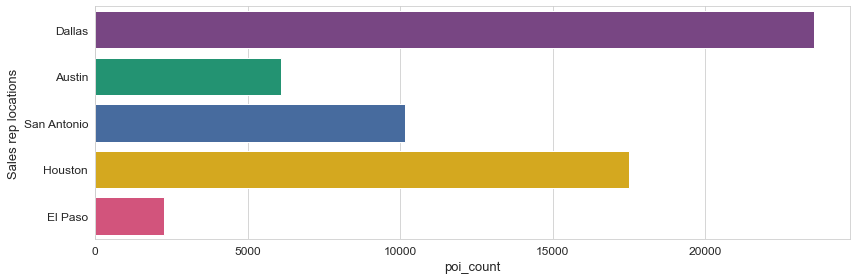

In [23]:
plot_cluster_comparison(sales_reps['city'].tolist(), areas, 'sales_rep_1_cat', poi_count='sum')

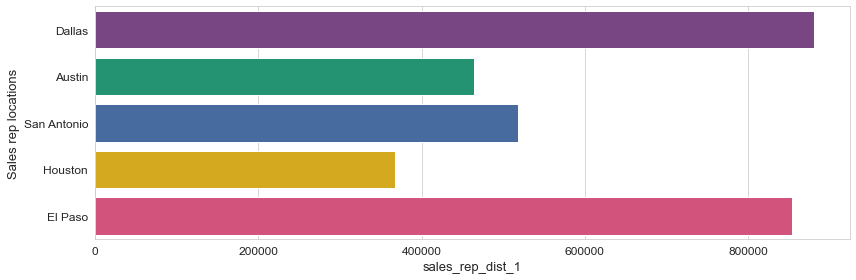

In [24]:
plot_cluster_comparison(sales_reps['city'].tolist(), areas[areas['poi_count']>0], 'sales_rep_1_cat', sales_rep_dist_1='max')

#### 3.3. Approach 2. Minimum Cost Flow

[Minimum cost flow](https://en.wikipedia.org/wiki/Minimum-cost_flow_problem#:~:text=The%20minimum%2Dcost%20flow%20problem,flow%20through%20a%20flow%20network.) is a well known type of problems in Optimization that finds the cheapest possible way of sending a certain amount of flow through a flow network. Initially it is not the approach to follow for spatial clustering problems. However, since we can represent our problem as a graph and interpret sales reps as source nodes and grid cells as sink nodes, we can use algorithms designed for Minimum Cost Flow problems for solving Two-Layer Territory Management use cases.

We will use [ortools pywrapgraph wrapper](https://developers.google.com/optimization/flow/mincostflow) as solver.

##### 3.3.1. Data preparation

We need to perform some extra data processing for in order tu use this algorithm.

**Balancing criteria**

We would like to balance clusters based on total number of clients and maximum distance. Normally we are not looking for a perfect balance, especially when dealing with more than one multiple criteria, and a balance tolerance is introduced. In our case, we will consider a tolerance of 10% in number of clients, which means that we allow clusters to be as much as 10% below the perfect balance.

*Note* if you get very unbalanced clusters in terms of maximum distance, you should set a higher tolerance.

*Note* we are only using the number of clients and the maximum distance to balance, but this dataset also has the number of employees per client and you might even have other data you might be interested in using. In order to introduce other criteria in this algorithm, you need to create a multidimensional index to combine all criteria. Distance may or may not be included as it is always treated separately.

In [25]:
balance_tolerance = 0.1  # 10%
max_pois= int(np.round((1+balance_tolerance) * areas['poi_count'].sum()/sales_reps.shape[0]))
print('The maximum number of clients a sales rep can have assigned is', max_pois)

The maximum number of clients a sales rep can have assigned is 13102


**Pairwise distance**

First, we need pairwise distances between cells. We will use the euclidean distance in this case.

In [26]:
catesian_dist = cdist(gpd.GeoSeries(areas['rep_point'], crs='epsg:4326').to_crs('epsg:26914').apply(lambda point:[point.x, point.y]).tolist(),
                      gpd.GeoSeries(areas['rep_point'], crs='epsg:4326').to_crs('epsg:26914').apply(lambda point:[point.x, point.y]).tolist())

**Consider all cells**

Even though we only care about cells with clients, we will consider all of them to reduce complexity. This way, we only need to consider contiguous cells as adjacent, otherwise we would need to define some k-nearest weights to make sure we can get from one cell to any other.

In order for the algorithm to not disregard cells without clients, we artifically add 1 to all cells.

In [27]:
areas['poi_count'] = areas['poi_count']+1

**Graph component data**

Next, we need to generate all information required by the algorithm, namely:
- Adjacency matrix
- Edges, unit cost, capacity, and supply/demand

*Adjacency matrix*

We will use [Rook weights](https://pysal.org/libpysal/generated/libpysal.weights.Rook.html) which considers two polygons to be contiguous if they share one edge.

In [28]:
wgt = Rook.from_dataframe(areas, geom_col='geometry')

In [29]:
wgt.histogram

[(2, 5), (3, 65), (4, 123), (5, 69), (6, 2322)]

*Edges, unit cost, capacity, and supply/demand*

Here we create all graph components required by the algorithm.

In [31]:
# Starting idx for sales reps and default sink
sales_reps_first_idx = areas.shape[0]
default_sink_idx = sales_reps_first_idx + sales_reps.shape[0]

# Default sink demand
default_sink_demand = int(max_pois*sales_reps.shape[0]-areas['poi_count'].sum())

# Edges, unit cost, and capacity for grid cell connections
graph_info_nd_array = [[i, k, max_pois, int(np.round(catesian_dist[i][k]/1e3))] for i in range(len(wgt.cardinalities)) for k in wgt[i]]

# Default sink unit cost
default_sink_ucost = np.transpose(graph_info_nd_array)[-1].max()+1

# Edges, unit cost, and capacity for sales rep - cell connections and default sink
for idx, row in gpd.sjoin(sales_reps, areas).iterrows():
    # default sink
    graph_info_nd_array.append([sales_reps_first_idx+idx, default_sink_idx, max_pois, default_sink_ucost])
    # same cell connection
    cell_id = row['index_right']
    graph_info_nd_array.append([sales_reps_first_idx+idx, cell_id, max_pois, 0])
    
# DataFrame with edges, unit cost, and capacity
graph_info = pd.DataFrame(graph_info_nd_array, columns=['start_node', 'end_node', 'capacity', 'unit_cost'])
graph_info.tail(10)

start_node  end_node  capacity  unit_cost
14974        2584      2589     13102         20
14975        2584       255     13102          0
14976        2585      2589     13102         20
14977        2585      1850     13102          0
14978        2586      2589     13102         20
14979        2586      1165     13102          0
14980        2587      2589     13102         20
14981        2587      2235     13102          0
14982        2588      2589     13102         20
14983        2588       547     13102          0

##### 3.3.2. Calculate clusters

We first build the graph with all its information.

In [32]:
# Instantiate a SimpleMinCostFlow solver.
min_cost_flow = pywrapgraph.SimpleMinCostFlow()

# Add edges, unit costs, and capacities
for idx, row in graph_info.iterrows():
    min_cost_flow.AddArcWithCapacityAndUnitCost(row['start_node'].item(), row['end_node'].item(), row['capacity'].item(), row['unit_cost'].item())
    
# Add supply/demand
for idx, row in areas.iterrows():
    min_cost_flow.SetNodeSupply(idx, -row['poi_count'])
    
for idx, row in sales_reps.iterrows():
    min_cost_flow.SetNodeSupply(sales_reps_first_idx+idx, max_pois)
    
min_cost_flow.SetNodeSupply(default_sink_idx, -default_sink_demand)

We're ready to solve now.

In [33]:
if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
    print('Minimum cost:', min_cost_flow.OptimalCost())
    '''print('')
    print('  Arc    Flow / Capacity  Cost')
    for i in range(min_cost_flow.NumArcs()):
        cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
        print('%1s -> %1s   %3s  / %3s       %3s' % (
        min_cost_flow.Tail(i),
        min_cost_flow.Head(i),
        min_cost_flow.Flow(i),
        min_cost_flow.Capacity(i),
        cost))'''
else:
    print('There was an issue with the min cost flow input.')

Minimum cost: 11903441


##### 3.3.3. Label grid cells

As a solution of the Minimum Cost Flow problem, we have a graph with 5 components, one per cluster. In order to infer the cluster to which each cell belongs, we need to recursively explore the graph.

Let's first build the solution graph.

In [34]:
SG = nx.DiGraph()

nodes = [(i, {'color':'blue'}) for i in range(areas.shape[0])]
nodes += [(i+sales_reps_first_idx, {'color':'red'}) for i in range(sales_reps.shape[0])]
SG.add_nodes_from(nodes)

edges = []
total = 0
for i in range(min_cost_flow.NumArcs()):
    if min_cost_flow.Flow(i) > 0.1 and min_cost_flow.Head(i) != default_sink_idx: 
        edges.append((min_cost_flow.Tail(i), min_cost_flow.Head(i)))
        total +=1
        
SG.add_edges_from(edges)

'''pos = areas['rep_point'].apply(lambda point:(point.x, point.y)).tolist() +\
      sales_reps.apply(lambda row: (row['lon'], row['lat']), axis=1).tolist()
pos = dict(zip(list(range(len(nodes))), pos))

plt.figure(figsize=(18, 18))

node_color = ['blue']*areas.shape[0] + ['red']*sales_reps.shape[0]
nx.draw(SG, node_size=5, pos=pos,width=0.1, edge_color='grey', node_color=node_color)
#nx.draw(SG, node_size=5,width=0.1, edge_color='grey', node_color=node_color)'''
print('')

Let's now calculate each cell's cluster.

In [35]:
def tag_successors(successors, cluster, sol_dict):
    for s in successors:
        
        if sol_dict.get(s) is None:
            sol_dict[s] = cluster
        elif sol_dict[s] != cluster:
            # Border cells can be assign to more than one cluster.
            #print(f'Watch out! Node {s} belongs to clusters {sol_dict.get(s)} and {cluster}')
            pass
        else:
            # Already tagged path
            continue
            
        if len(list(SG.successors(s))) == 0:
            pass
        else:
            tag_successors(SG.successors(s), cluster, sol_dict)

sol_dict = dict()
for cluster in range(sales_reps.shape[0]):
    successors = list(SG.successors(sales_reps_first_idx+cluster))
    tag_successors(successors, sales_reps_first_idx+cluster, sol_dict)  

In [36]:
assert(len(sol_dict)==areas.shape[0])

In [37]:
areas['sales_rep_2'] = list({k: v for k, v in sorted(sol_dict.items(), key=lambda item:item[0])}.values())
areas['sales_rep_2'] -= sales_reps_first_idx
areas['sales_rep_2_cat'] = sales_reps.loc[areas['sales_rep_2'], 'city'].tolist()
areas.head()

hex_id                                           geometry  \
0  8526d9d7fffffff  POLYGON ((-99.33557 32.87875, -99.26773 32.953...   
1  8526d9a3fffffff  POLYGON ((-98.71570 32.47235, -98.64788 32.546...   
2  8526dc1bfffffff  POLYGON ((-100.32151 34.39136, -100.25314 34.4...   
3  85446c77fffffff  POLYGON ((-94.98183 29.87978, -94.91454 29.952...   
4  85444db7fffffff  POLYGON ((-95.10421 32.87010, -95.03517 32.941...   

   poi_count  employee_avg                    rep_point  sales_rep_1  \
0          1      0.000000   POINT (-99.37959 32.96652)            0   
1          1      0.000000   POINT (-98.75897 32.56035)            0   
2          1      0.000000  POINT (-100.36707 34.47834)            0   
3         14      3.833333   POINT (-95.02049 29.96866)            3   
4          2      3.000000   POINT (-95.14402 32.95831)            0   

  sales_rep_1_cat  sales_rep_dist_1  sales_rep_2 sales_rep_2_cat  
0          Dallas     262156.516612            4         El Paso  
1          Dallas     199715.113991            4         El Paso  
2          Dallas     520625.827092            4         El Paso  
3         Houston      51541.627399            3         Houston  
4          Dallas     188844.476467            0          Dallas

In [38]:
areas['sales_rep_dist_2'] = areas.apply(lambda row : dist_array[row.name, row.sales_rep_2], axis=1)

In [39]:
areas['poi_count'] = areas['poi_count']-1

##### 3.3.4. Visualize and analyze results

We can see how the number of clients per cluster is more balanced now with the exception of El Paso. This issue was already identified at the beginning of the analysis. In order to double the number of clients for El Paso, we went from a maximum distance of 840 km to more than 1150 km, doubling the max distance of the cluster with the second highest max distnace.

Next step would be to play with the balance tolerance to give a higher priority to distance or to the number of clients.

The following layout map compares the clusters generated by both techniques.

In [44]:
Layout([Map([Layer(areas[areas['poi_count'] > 0],
                   style=color_category_style('sales_rep_1_cat', cat=sales_reps['city'].tolist()), 
                   legends=color_category_legend('Closest Distance', 'Sales Reps'), encode_data=False),
             Layer(sales_reps, 
                   style=basic_style(color='black'))]),
        Map([Layer(areas[areas['poi_count'] > 1],
                   style=color_category_style('sales_rep_2_cat', cat=sales_reps['city'].tolist()), 
                   legends=color_category_legend('Min Cost Flow', 'Sales Reps'), encode_data=False),
             Layer(sales_reps, 
                   style=basic_style(color='black'))])
        ], map_height=400)

The following two charts show the number of clients and maximum distance per cluster, respectively.

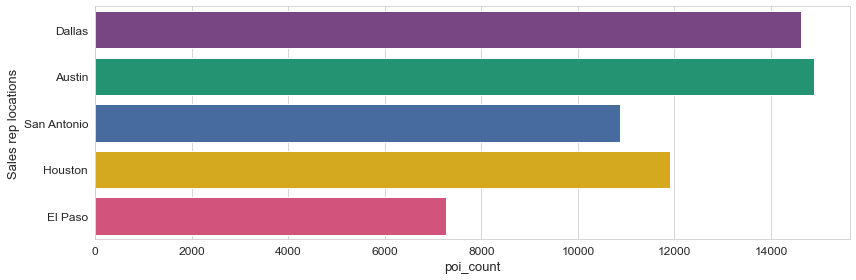

In [42]:
plot_cluster_comparison(sales_reps['city'].tolist(), areas, 'sales_rep_2_cat', poi_count='sum')

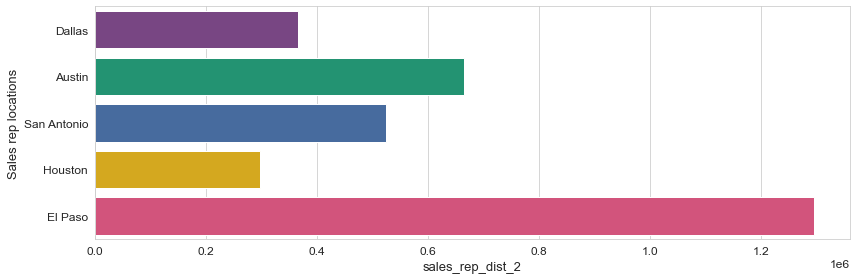

In [43]:
plot_cluster_comparison(sales_reps['city'].tolist(), areas, 'sales_rep_2_cat', sales_rep_dist_2='max')